Hugging face Babelscape/rebel-large model

In [ ]:
!pip install python-dotenv
!pip install datasets
!pip install langchain
!pip install transformers
!pip install neo4j
!pip install -U huggingface_hub
pip install torch

In [1]:
import os
import random
import json
import hashlib
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm.auto import tqdm
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [2]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('../data/Football_news.pdf')
pages = loader.load_and_split()

contents=''
for i in range(0,len(pages)):
    contents=' '.join([contents,pages[i].page_content.replace('\n',' ')])

In [3]:
#Creating chunks using langchain RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)

chunks = text_splitter.split_text(contents)
#chunk_documents = text_splitter.create_documents([contents])

In [ ]:
#to add id to the chunks
# m = hashlib.md5()
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# data = []
# m = hashlib.md5()
# m.update(contents.encode('utf-8'))
# uid = m.hexdigest()[:12]

# for i, chunk in enumerate(chunks):
#         data.append({
#             'id': f'{uid}-{i}',
#             'text': chunk
#         })

In [4]:
""" Extract triplets from text
     
     input : string text
     ouput: list of tuple (triplets in the form of [source, relation, target])

"""

def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

gen_kwargs = {
    "max_length": 256,
    "length_penalty": 0,
    "num_beams": 3,
    "num_return_sequences": 1,
}

triples = []

In [7]:
def generate_triples(texts):

  model_inputs = tokenizer(texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
  generated_tokens = model.generate(
      model_inputs["input_ids"].to(model.device),
      attention_mask=model_inputs["attention_mask"].to(model.device),
      **gen_kwargs
  )
  decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)
  for idx, sentence in enumerate(decoded_preds):
      et = extract_triplets(sentence)
      for t in et:
        triples.append((t['head'], t['type'], t['tail']))

In [8]:
for i in tqdm(range(0, len(chunks), 2)):
    try:
        texts = [chunks[i], chunks[i+1]]
    except:
        texts = [chunks[i]]
    generate_triples(texts)

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
distinct_triples = list(set(triples))
distinct_triples

[('Miami', 'home venue', 'Cotton Bowl Stadium'),
 ('Cotton Bowl Stadium', 'occupant', 'Miami'),
 ('Chinese', 'continent', 'Asia'),
 ('Old Boys', 'point in time', 'February 15'),
 ('MLS', 'subsidiary', 'Real Salt Lake'),
 ('Real Salt Lake', 'league', 'MLS'),
 ('Tokyo', 'country', 'Japan'),
 ('Sergio Busquets', 'member of sports team', 'Barcelona'),
 ('Lionel Messi', 'member of sports team', 'Inter Miami'),
 ('Jesus Ferreira', 'member of sports team', 'Dallas'),
 ('Al -Hilal', 'country', 'Saudi Arabia'),
 ('Vissel Kobe', 'country', 'Japan'),
 ('Al -Nassr', 'country', 'Saudi Arabia'),
 ('Luis Suarez', 'member of sports team', 'Barcelona'),
 ('Maarten Paes', 'member of sports team', 'Dallas'),
 ('Jesus Ferreira', 'member of sports team', 'US')]

In [11]:
import neo4j
from neo4j import GraphDatabase
from dotenv import load_dotenv

load_dotenv()

# Connect to the Neo4j database
URI = os.environ['NEO4J_URI']
USER = os.environ['NEO4J_USERNAME']
PASSWORD = os.environ['NEO4J_PASSWORD']
AUTH = (USER, PASSWORD)

driver = GraphDatabase.driver(URI, auth=AUTH)
driver.verify_authentication()

def create_triplets(tx, triplet) :
    tx.run("MERGE (s:Node {name: $source})", source=triplet[0]) 
    tx.run("MERGE (t:Node {name: $target})", target=triplet[2]) 
    tx.run("MATCH (s:Node {name: $source}), (t:Node {name: $target}) MERGE (s)-[r:Relation {name: $relation} ]->(t)" ,
        source=triplet[0], relation=triplet[1], target=triplet[2])
    
    #MERGE (source)-[r: \`${sanitisedRelationshipType}\`]->(target)`)
    
with driver.session() as session:
    for triplet in distinct_triples:
        session.execute_write(create_triplets, triplet)


Observations :

Node count = 23
Relation count = 16

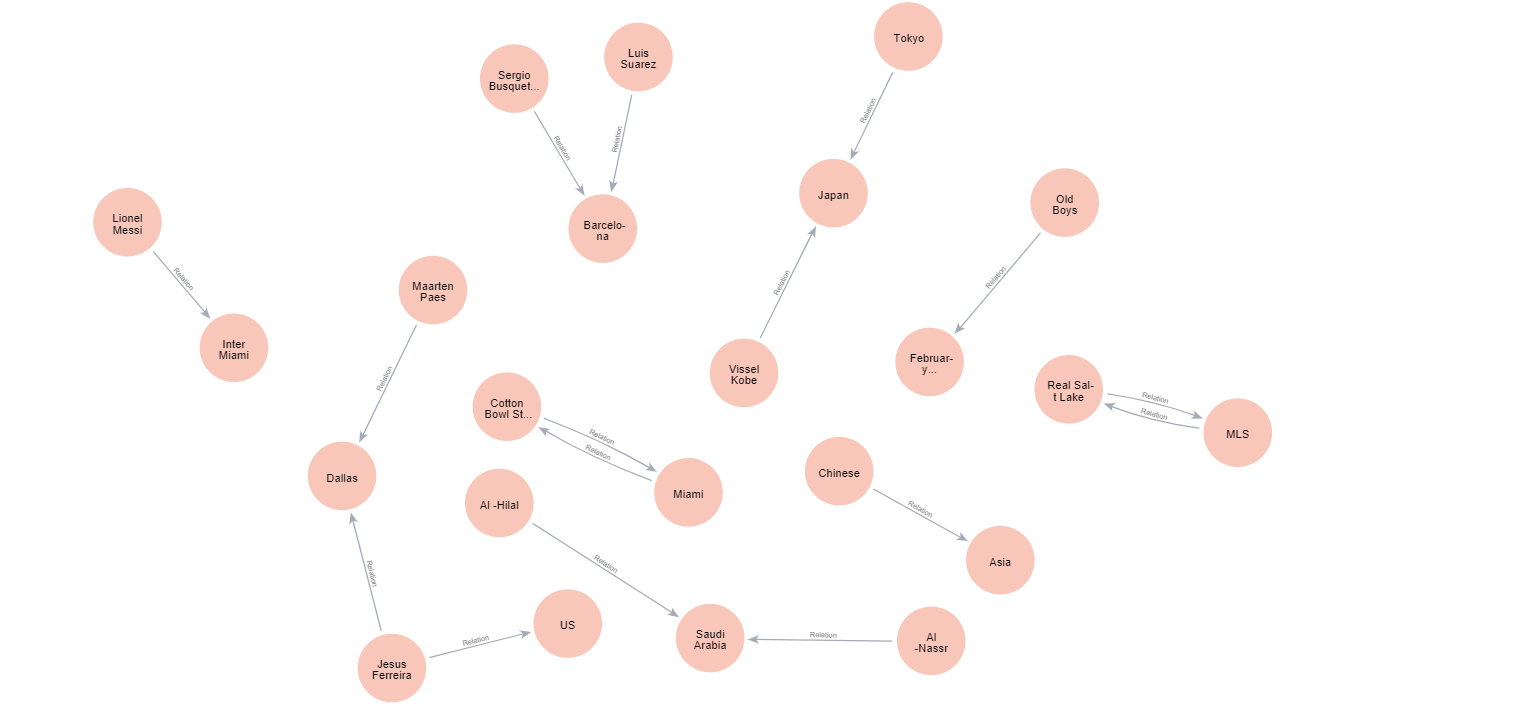